<a href="https://colab.research.google.com/github/MRazin172/Speech_Processing/blob/main/2348534_SPR_LabProgram4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import librosa
from scipy.signal import lfilter
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz  # Correct import for toeplitz function
from scipy.signal import lfilter

# Function to calculate LPC coefficients
def lpc(signal, order):
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    R = autocorr[:order + 1]
    R_matrix = toeplitz(R[:-1])  # Corrected to use scipy's toeplitz function
    R_vector = -R[1:]

    lpc_coeffs = np.linalg.solve(R_matrix, R_vector)
    lpc_coeffs = np.concatenate(([1], lpc_coeffs))

    return lpc_coeffs

# Load the recorded speech signal
file_path = '/content/16-122828-0002.wav'  # Replace with your file path
speech_signal, sr = librosa.load(file_path, sr=None)

# Frame the signal (20ms frames)
frame_size = int(0.02 * sr)  # 20ms window
frame_shift = int(0.01 * sr)  # 10ms shift
num_frames = (len(speech_signal) - frame_size) // frame_shift + 1

# Set LPC order (typically 8-16 for speech signals)
lpc_order = 12

# List to store LPC coefficients
lpc_coefficients = []
reconstructed_signal = np.zeros_like(speech_signal)

# Loop through each frame
for i in range(num_frames):
    start_idx = i * frame_shift
    end_idx = start_idx + frame_size

    frame = speech_signal[start_idx:end_idx]
    if len(frame) == frame_size:
        # Calculate LPC coefficients for this frame
        coeffs = lpc(frame, lpc_order)
        lpc_coefficients.append(coeffs)

        # Reconstruct the signal frame using the LPC filter
        reconstructed_frame = lfilter([1], coeffs, frame)

        # Overlap-add method to reconstruct the full signal
        reconstructed_signal[start_idx:end_idx] += reconstructed_frame


lpc_coefficients = np.array(lpc_coefficients)

print("LPC Coefficients for each frame:")
print(lpc_coefficients)



LPC Coefficients for each frame:
[[ 1.         -0.7513535  -0.05238559 ...  0.16976513 -0.12065385
   0.00152481]
 [ 1.         -0.62335658  0.03477247 ...  0.16509235 -0.04922103
  -0.10589824]
 [ 1.         -0.75591624  0.30143371 ...  0.09307028  0.02926249
  -0.11913825]
 ...
 [ 1.         -0.94201189  0.35567287 ...  0.0944863  -0.02703216
  -0.02929203]
 [ 1.         -0.96040529  0.33902103 ...  0.07558744  0.02638688
  -0.06482307]
 [ 1.         -0.92859036  0.24159788 ... -0.00206717  0.1079888
  -0.07004124]]


In [ ]:
print("Shape of LPC Coefficients:", lpc_coefficients.shape)


Shape of LPC Coefficients: (289, 13)


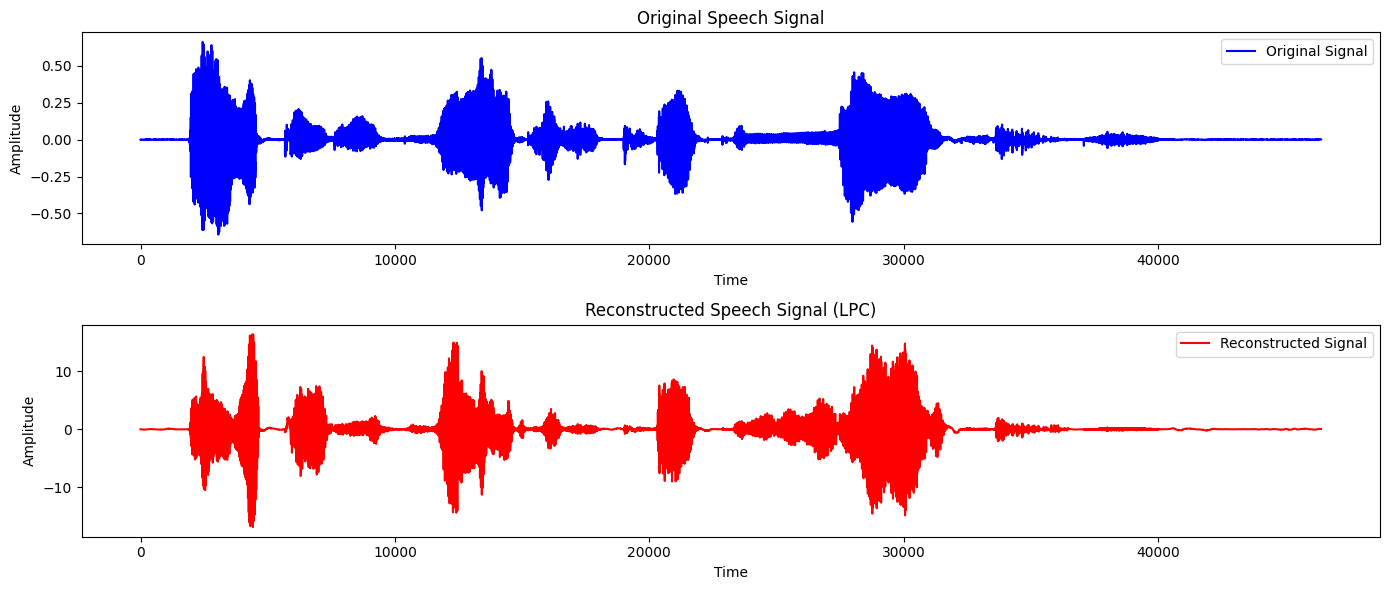

In [ ]:
plt.figure(figsize=(14, 6))

# Plot original signal
plt.subplot(2, 1, 1)
plt.plot(speech_signal, label="Original Signal", color='blue')
plt.title('Original Speech Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Plot reconstructed signal
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label="Reconstructed Signal", color='red')
plt.title('Reconstructed Speech Signal (LPC)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

Estimated Formants: [   0.            0.          903.00846381 2449.3495778  3885.82050866
 5696.85124306 7109.81799052]

Expected formants for /a/: [730, 1090, 2440]
Estimated formants: [  0.           0.         903.00846381]


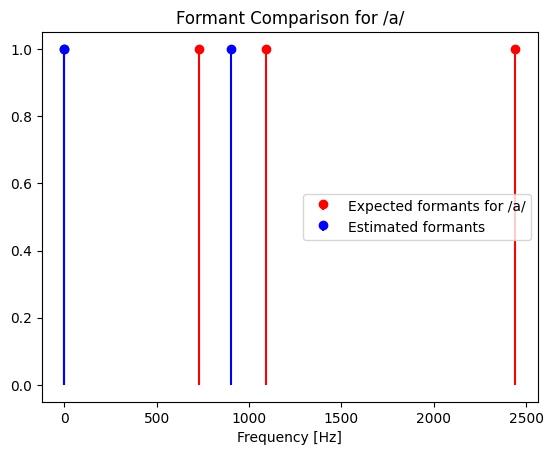


Expected formants for /e/: [660, 1700, 2400]
Estimated formants: [  0.           0.         903.00846381]


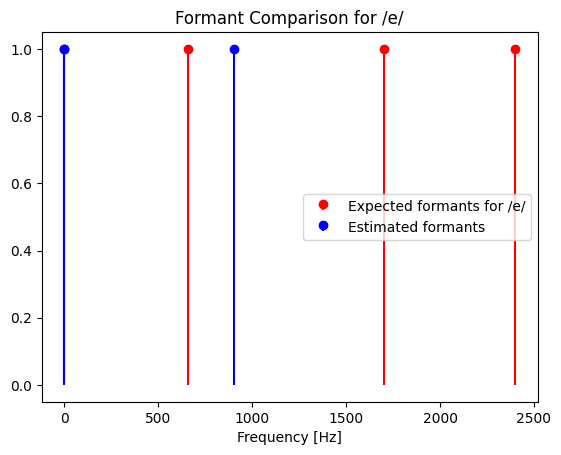


Expected formants for /i/: [270, 2290, 3010]
Estimated formants: [  0.           0.         903.00846381]


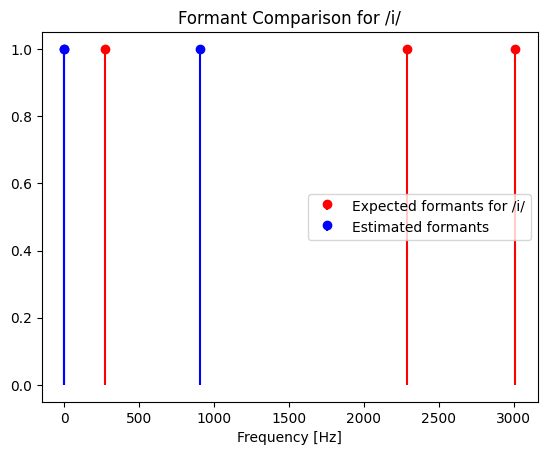


Expected formants for /o/: [460, 1020, 2300]
Estimated formants: [  0.           0.         903.00846381]


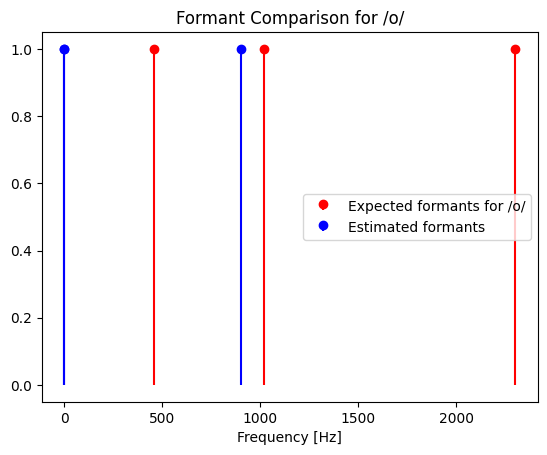


Expected formants for /u/: [300, 870, 2240]
Estimated formants: [  0.           0.         903.00846381]


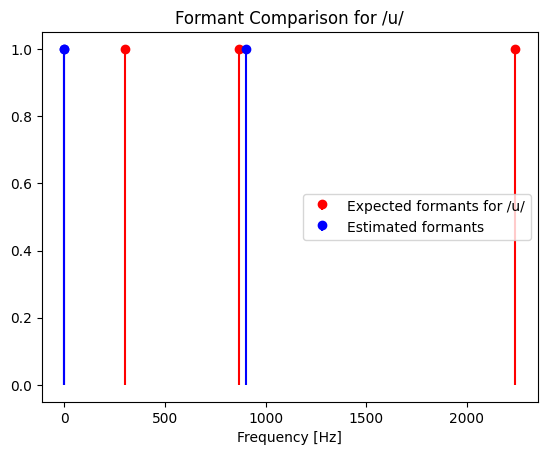

In [ ]:
def get_formants(lpc_coeffs, sr):
    # Get the roots of the LPC polynomial
    roots = np.roots(lpc_coeffs)

    # Filter out roots with imaginary parts (only keep roots with positive imaginary parts)
    roots = [r for r in roots if np.imag(r) >= 0]

    # Calculate formant frequencies from the roots
    formant_frequencies = np.angle(roots) * (sr / (2 * np.pi))

    # Sort the formants by frequency
    formant_frequencies = np.sort(formant_frequencies)

    return formant_frequencies

frame_size = int(0.02 * sr)  # 20ms window
frame = speech_signal[:frame_size]

# Calculate LPC coefficients for the frame
lpc_coeffs = lpc(frame, lpc_order)

# Estimate the formants from the LPC coefficients
formants = get_formants(lpc_coeffs, sr)

# Display the estimated formants
print(f"Estimated Formants: {formants}")

# Compare the estimated formants to typical vowel formants

# Typical formant frequencies for vowels (Hz)
vowel_formants = {
    '/a/': [730, 1090, 2440],
    '/e/': [660, 1700, 2400],
    '/i/': [270, 2290, 3010],
    '/o/': [460, 1020, 2300],
    '/u/': [300, 870, 2240]
}

# Compare formants to expected vowel formants
for vowel, expected_formants in vowel_formants.items():
    print(f"\nExpected formants for {vowel}: {expected_formants}")
    print(f"Estimated formants: {formants[:len(expected_formants)]}")

    # Plot comparison
    plt.figure()
    plt.stem(expected_formants, np.ones(len(expected_formants)), linefmt='r-', markerfmt='ro', basefmt=" ", label=f'Expected formants for {vowel}')
    plt.stem(formants[:len(expected_formants)], np.ones(len(expected_formants)), linefmt='b-', markerfmt='bo', basefmt=" ", label='Estimated formants')
    plt.title(f'Formant Comparison for {vowel}')
    plt.xlabel('Frequency [Hz]')
    plt.legend()
    plt.show()

In [ ]:
from scipy.signal import freqz

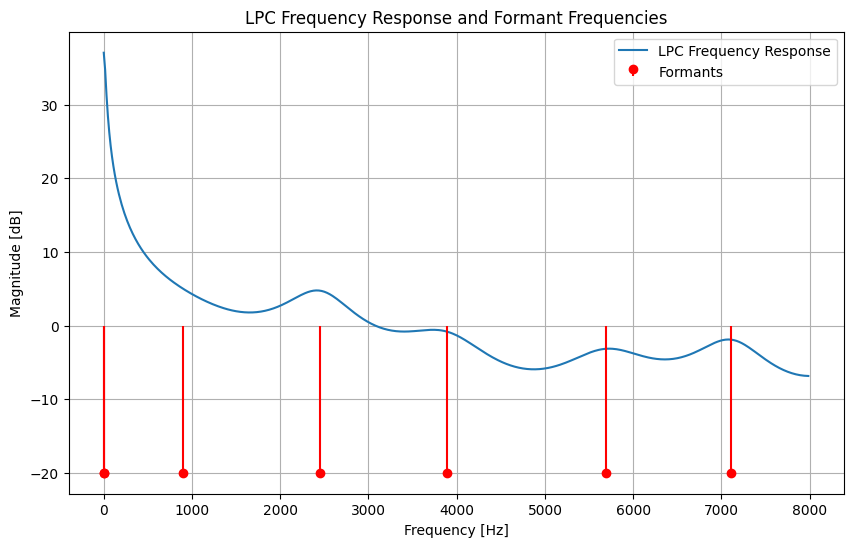

In [ ]:
w, h = freqz(1, lpc_coeffs, worN=512, fs=sr)

# Plot the frequency response and formant frequencies
plt.figure(figsize=(10, 6))

# Plot LPC frequency response
plt.plot(w, 20 * np.log10(np.abs(h)), label='LPC Frequency Response')

# Mark the formants on the frequency response plot
plt.stem(formants, np.ones(len(formants)) * -20, linefmt='r-', markerfmt='ro', basefmt=" ", label='Formants')

# Add labels and title
plt.title('LPC Frequency Response and Formant Frequencies')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

### Brief Note on LPC Model Implementation

The implementation of the Linear Predictive Coding (LPC) model serves as a powerful tool for analyzing and synthesizing speech signals. By leveraging the principles of LPC, we can effectively capture the resonant characteristics of the vocal tract, which are crucial for understanding speech production and perception. Here’s a brief inference about the execution of the LPC model implementation:

1. **Signal Preprocessing**:
   - The speech signal is first loaded and preprocessed to ensure it is suitable for analysis. This typically involves framing the signal into manageable segments, allowing for localized analysis of its characteristics.

2. **LPC Coefficient Calculation**:
   - Using the autocorrelation method, the LPC coefficients are computed from a given frame of the speech signal. These coefficients represent the filter that models the speech production system, capturing the spectral envelope of the vocal tract.

3. **Formant Estimation**:
   - The roots of the LPC polynomial are calculated to estimate the formant frequencies. Formants are crucial resonant frequencies in speech that help distinguish different phonetic sounds, especially vowels. The estimated formant frequencies provide insight into the vocal tract's configuration during speech production.

4. **Frequency Response Analysis**:
   - The frequency response of the LPC filter is computed and visualized. This response shows how the filter amplifies or attenuates different frequencies, allowing us to observe the peaks corresponding to formants. This analysis is vital for understanding how the vocal tract shapes the speech signal.

5. **Visualization**:
   - By plotting both the LPC frequency response and the estimated formant frequencies, we can visually assess how well the LPC model captures the resonances present in the speech signal. The plot highlights the relationship between the spectral characteristics of the speech and the formants, facilitating a better understanding of speech production.

6. **Applications**:
   - The LPC model finds extensive applications in speech coding, recognition, and synthesis. By compressing speech signals effectively, LPC enables efficient transmission and storage of audio data, while also serving as a foundational technique in modern speech recognition systems.

### Conclusion
The LPC model implementation demonstrates the ability to analyze and synthesize speech effectively. By modeling the vocal tract's characteristics, LPC provides essential insights into speech production, enabling advancements in various fields such as telecommunications, speech therapy, and human-computer interaction. The visualization of formants and the frequency response reinforces our understanding of how speech sounds are generated and perceived, highlighting LPC's significance in speech processing.